Experiments with disk potential.

In [200]:
%config InlineBackend.figure_format="retina"
%config Completer.use_jedi = False

In [363]:
pwd

'/data/apcooper/projects/sgarrak/notebooks/disks'

In [364]:
import sys
import os
import time

import numpy as np
import tables as tb
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
import astropy.cosmology as cosmo

from astropy.table import Table

import copy

SATGEN_PATH = '/data/apcooper/sfw/SatGen'
if not SATGEN_PATH in sys.path:
    sys.path.append(SATGEN_PATH)

SATGEN_ETC_PATH = '/data/apcooper/sfw/SatGen/etc'
if not SATGEN_ETC_PATH in sys.path:
    sys.path.append(SATGEN_ETC_PATH)
    
# SatGen Imports
import config as cfg
import cosmo as co
import evolve as ev
from   profiles import NFW,Dekel,MN,Einasto,Green
from   orbit import orbit
import galhalo as gh
import aux
import init

In [365]:
from importlib import reload

SGARRAK_PATH = '/data/apcooper/projects/sgarrak/py/'
if not SGARRAK_PATH in sys.path:
    sys.path.append(SGARRAK_PATH)
import sgarrak.sgarrak as sga
reload(sga)

<module 'sgarrak.sgarrak' from '/data/apcooper/projects/sgarrak/py/sgarrak/sgarrak.py'>

In [366]:
import matplotlib.pyplot as pl
%matplotlib inline

### Generate PCHTrees output

In [367]:
# Millennium Cosmology (should match whatever was used in PCHTrees)
hubble_parameter = 0.73
cosmology = cosmo.FlatLambdaCDM(hubble_parameter*100,0.25)

In [368]:
!ls ../ics_example/trees

output_progenitors_100_mw.hdf5	run_pchtrees_pfop_100_mw_debug.sh
pchtrees			run_pchtrees_pfop_100_mw.sh
pchtrees_pfop_100_mw.toml	satgen_level_zred_100myr_z3_z12.txt
README.md			slurm_run_pchtrees_pfop_100_mw.sh


In [369]:
!h5ls ../ics_example/trees/output_progenitors_100_mw.hdf5/Progenitors

HostMass                 Dataset {24775/Inf}
MergedMass               Dataset {24775/Inf}
MergedZred               Dataset {24775/Inf}
ProgenitorIlev           Dataset {24775/Inf}
ProgenitorMass           Dataset {24775/Inf}
ProgenitorZred           Dataset {24775/Inf}
TreeID                   Dataset {24775/Inf}


In [370]:
# Output of PCHTrees
tree_file = '../ics_example/trees/output_progenitors_100_mw.hdf5'

# Read main branch mass histories (immediately deal with little h)
tree_main_branch_masses = sga.read_hdf5(tree_file,'/Mainbranch/MainbranchMass')/hubble_parameter

# Number of treees and tree levels
ntrees, nlev = tree_main_branch_masses.shape

# Read progenitor data (immediately deal with little h on masses)
progenitor_dataset_names = ["HostMass","ProgenitorZred","ProgenitorMass","ProgenitorIlev","TreeID"]
    
progenitors = sga.read_hdf5(tree_file, progenitor_dataset_names, group='/Progenitors')
progenitors['ProgenitorMass'] = progenitors['ProgenitorMass']/hubble_parameter
progenitors['HostMass']       = progenitors['HostMass']/hubble_parameter

tree_redshifts = sga.read_hdf5(tree_file,'Redshift',group='/OutputTimes')
tree_t_lbk_gyr = cosmology.lookback_time(tree_redshifts).value
tree_t_age_gyr = cosmology.age(tree_redshifts).value

# Root mass is the the mass of the main branch at z=0
root_mass = tree_main_branch_masses[:,0]

In [371]:
ntrees

100

### Explore the progenitor file

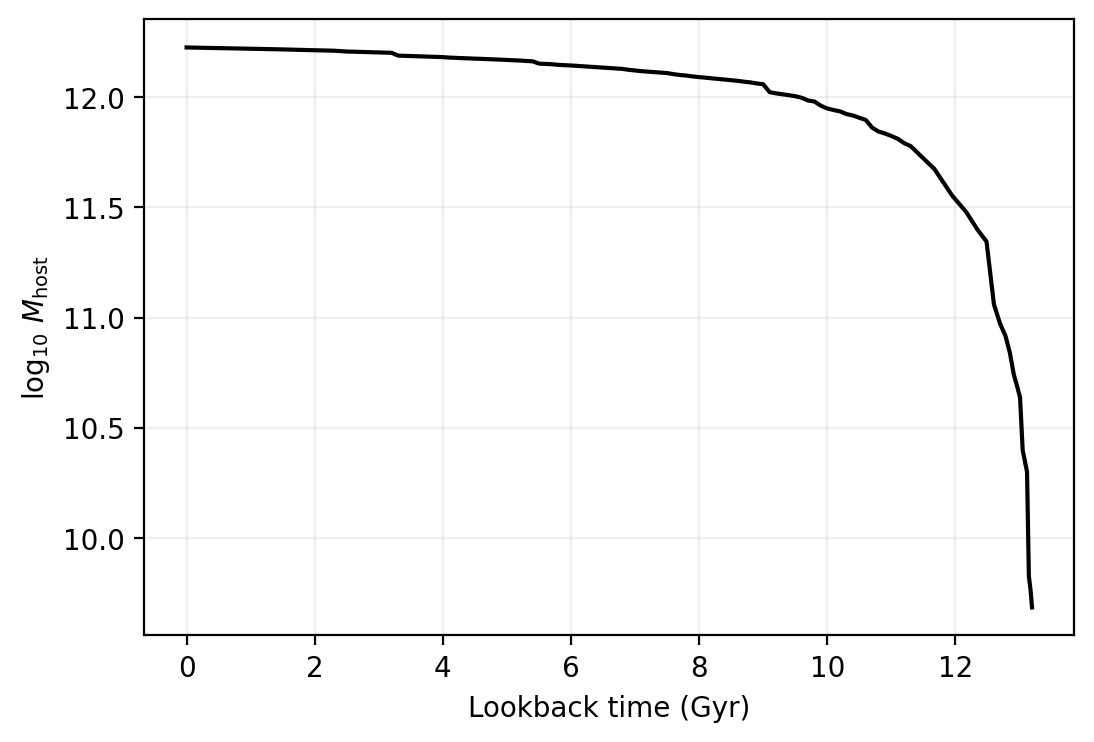

In [372]:
# An example tree
itree = 0

# Plot the mass growth history
pl.figure(figsize=(6,4))
pl.plot(tree_t_lbk_gyr, np.log10(tree_main_branch_masses[itree,:]),c='k')
pl.grid(alpha=0.2)
pl.xlabel('Lookback time (Gyr)')

pl.ylabel('$\log_{10}\,M_\mathrm{host}$');

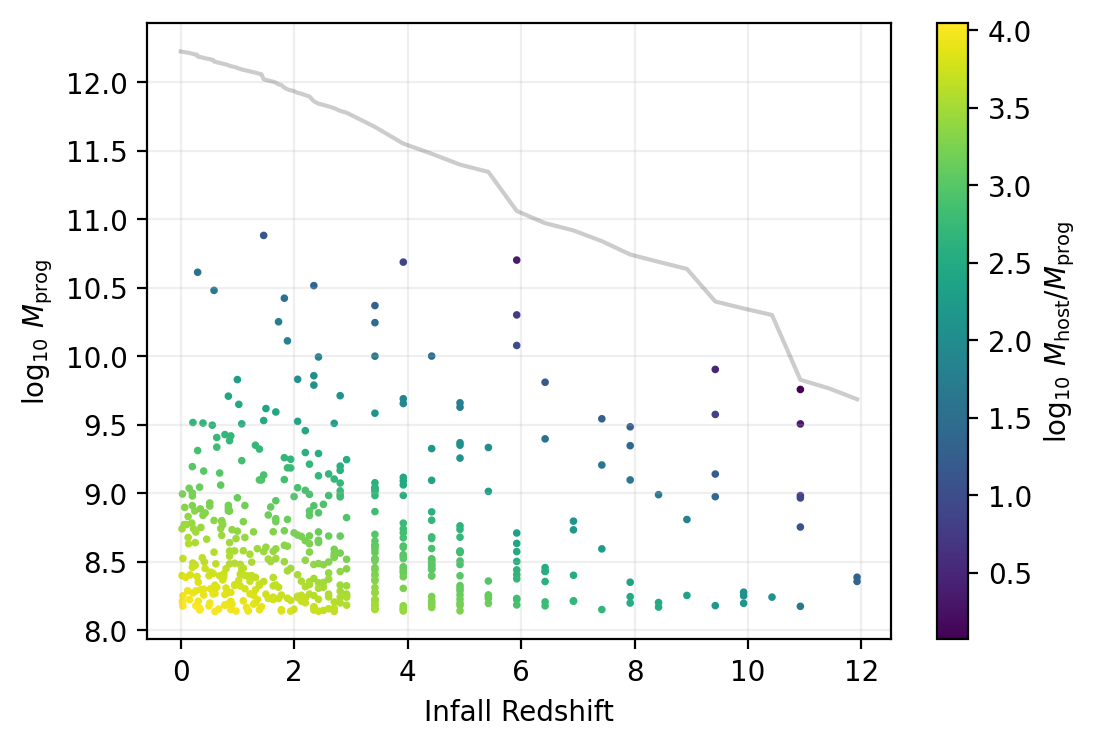

In [373]:
# Scatterplot progenitor masses and infall redshifts

# An example tree
itree = 0

prog_this_tree = np.flatnonzero(progenitors['TreeID'] == itree)

prog_zred = progenitors['ProgenitorZred'][prog_this_tree]
prog_ilev = progenitors['ProgenitorIlev'][prog_this_tree] 
prog_logm = np.log10(progenitors['ProgenitorMass'][prog_this_tree])

# Get the host mass at the infall redshift
host_mass = tree_main_branch_masses[itree,:]
host_logm_infall = np.log10(host_mass[prog_ilev])

logm_ratio = host_logm_infall - prog_logm

pl.figure(figsize=(6,4))
pl.scatter(prog_zred, 
           prog_logm,
           c=logm_ratio,
           s=3)
pl.colorbar(label='$\log_{10}\,M_\mathrm{host}/M_\mathrm{prog}$')

pl.plot(tree_redshifts, np.log10(tree_main_branch_masses[itree,:]),c='k',alpha=0.2)

pl.grid(alpha=0.2)
pl.xlabel('Infall Redshift')
pl.ylabel('$\log_{10}\,M_\mathrm{prog}$');

## Example 1: Static host potential

A simple example with *fixed* host and progenitor properties. You can change the progenitor mass to see what happens.

In [423]:
# Host is evolved from z=1 to z=0 with no evolution.
# Progenitor infall at z=1
np.random.seed(2026)
host = sga.Host([1e12,1e12], [0.0,1.0], fd=0.0, flattening=0.0, cosmology=cosmology)
prog = sga.Progenitor(1e9, host, zred=1.0)

In [424]:
np.random.seed(2026)
host_disk = sga.Host([1e12,1e12], [0.0,1.0], fd=0.1, flattening=1000, cosmology=cosmology)
prog_disk = sga.Progenitor(1e9, host_disk, zred=1.0)

In [425]:
np.random.seed(2026)
host_disk_lowflat = sga.Host([1e12,1e12], [0.0,1.0], fd=0.1, flattening=0.1, cosmology=cosmology)
prog_disk_lowflat = sga.Progenitor(1e11, host_disk_lowflat, zred=1.0)

In [426]:
# Note this total time is longer than the time difference between z=1 and z=0
# In this case it doesn't matter
total_time_gyr = 8.0
nsteps = 100

# tsteps grid and output array sizes will be nsteps+1,
# because the initial conditions are included at index zero (t=0)
tsteps = np.linspace(0, total_time_gyr, nsteps+1)

In [427]:
solution  = sga.evolve_orbit(host, prog, tsteps, evolve_prog_mass=False)

In [428]:
solution_disk = sga.evolve_orbit(host_disk, prog_disk, tsteps, evolve_prog_mass=False)

In [429]:
solution_disk_lowflat = sga.evolve_orbit(host_disk_lowflat, prog_disk_lowflat, tsteps, evolve_prog_mass=True)

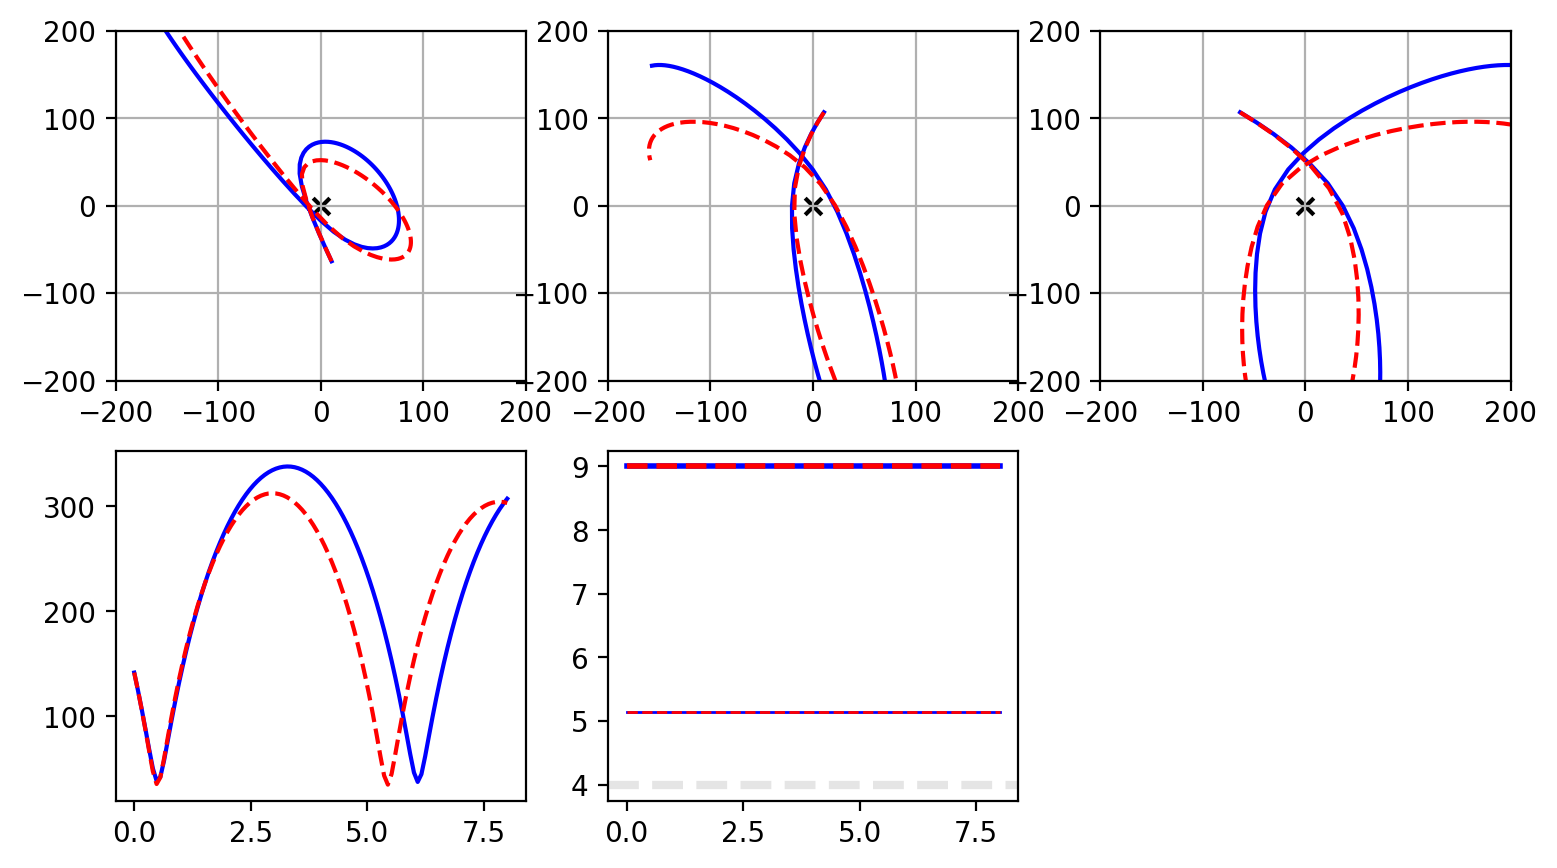

In [430]:
# Look a the results

pkwargs = {'solution': dict(c='b',ls='solid'),
           'solution_disk': dict(c='r',ls='--'),
           'solution_disk_lowflat': dict(c='g',ls=':')
          }

pl.figure(figsize=(9,5))

ax1 = pl.subplot(2,3,1)
ax2 = pl.subplot(2,3,2)
ax3 = pl.subplot(2,3,3)
ax4 = pl.subplot(2,3,4)
ax5 = pl.subplot(2,3,5)

for sname in ['solution','solution_disk']: # , 'solution_disk_lowflat']:
    s = locals()[sname]
    
    R = s['orbit'].xvArray[:,0]
    P = s['orbit'].xvArray[:,1]
    Z = s['orbit'].xvArray[:,2]
    
    X = R*np.cos(P)
    Y = R*np.sin(P)

    ax = pl.sca(ax1)
    pl.plot(X,Y,**pkwargs[sname])
    
    ax = pl.sca(ax2)
    pl.plot(X,Z,**pkwargs[sname])
    
    ax = pl.sca(ax3)
    pl.plot(Y,Z,**pkwargs[sname])

    ax = pl.sca(ax4)
    pl.plot(s['tsteps'],s['radii'],**pkwargs[sname])

    ax = pl.sca(ax5)
    pl.plot(s['tsteps'],np.log10(s['prog_masses']),**(pkwargs[sname] | dict(lw=2)))
    pl.plot(s['tsteps'],np.log10(s['prog_mstars']),**(pkwargs[sname] | dict(lw=1)))

pl.sca(ax5)

# This "resolution limit" phi_res is built in to the satgen orbit integrator;
# It can be adjusted by setting cfg.phi_res before the evolution calculation.
# The orbit is not updated after the total mass reaches this limit.
halo_mass_resolution_limit_rel = cfg.phi_res*prog.dens_profile.Mh
pl.axhline(np.log10(halo_mass_resolution_limit_rel),c='k',alpha=0.1,lw=3,ls='--')

# There is another "resolution limit"  built in to the satgen orbit integrator,
# cfg.Mres. In this case the limit is in absolute rather than relative mass.
# Again, the orbit is not updated after the total mass reaches this limit. 
# By default, cfg.Mres is None.
if cfg.Mres is not None:
    halo_mass_resolution_limit_abs = cfg.Mres
    pl.axhline(np.log10(halo_mass_resolution_limit_abs),c='g',alpha=0.1,lw=3,ls='--')

# Note that strange things happen if both limits are set and 
# cfg.Mres < cfg.phi_res * (initial halo mass)
    
pl.legend(frameon=False)

for ax in [ax1,ax2,ax3]:
    pl.sca(ax)
    pl.scatter([0],[0],c='k',marker='x')
    pl.grid()
    pl.xlim(-200,200)
    pl.ylim(-200,200)

(-1.0, 11.0)

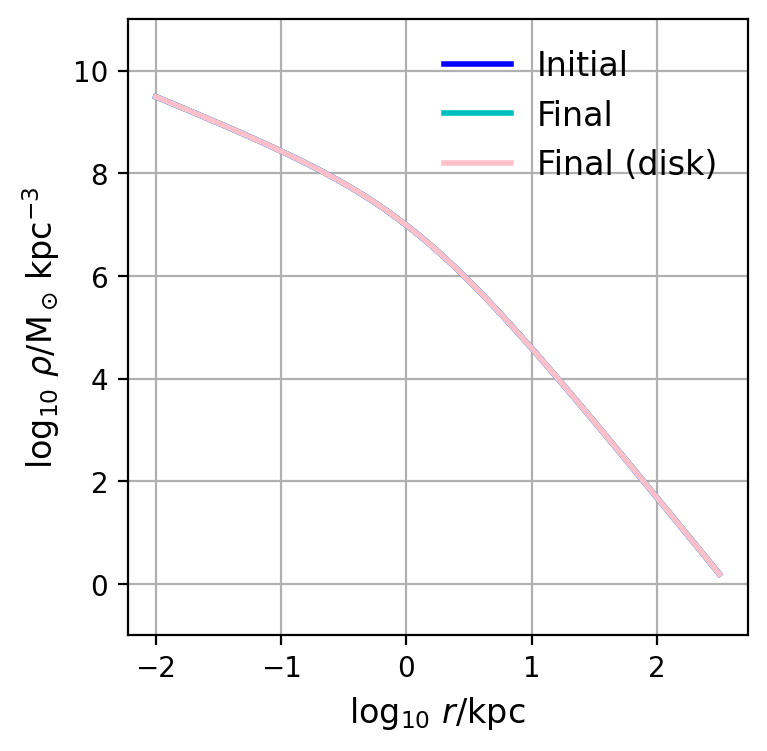

In [431]:
# Initial and final total density profile of the progenitor

pl.figure(figsize=(4,4))

log_r = np.logspace(-2,2.5)
log_rho = np.log10(prog.dens_profile.rho(log_r))
pl.plot(np.log10(log_r),log_rho,label='Initial',c='b',lw=2)

log_rho = np.log10(solution['prog_dp'].rho(log_r))
pl.plot(np.log10(log_r),log_rho,label='Final',c='c',lw=2)

log_rho = np.log10(solution_disk['prog_dp'].rho(log_r))
pl.plot(np.log10(log_r),log_rho,label='Final (disk)',c='pink',lw=2)

pl.grid()
pl.xlabel(r'$\log_{10}\,r/\mathrm{kpc}$',fontsize=12)
pl.ylabel(r'$\log_{10}\,\rho/\mathrm{M_\odot \, kpc^{-3}}$',fontsize=12)
pl.legend(frameon=False,fontsize=12);
pl.ylim(-1,11)

## Example 2: Single progenitor from a merger tree

In [432]:
# The list of progenitor IDs from the first tree, in decreasing order of mass

In [433]:
prog_this_tree = np.flatnonzero(progenitors['TreeID'] == itree)

np.argsort(progenitors['ProgenitorMass'][prog_this_tree])[::-1]

array([163, 432, 351,  36, 244,  67, 195, 313, 433, 189, 314, 201, 434,
       377, 315, 254, 473, 245, 215, 119, 445, 246, 482, 290,  96, 352,
       403, 353, 122, 404, 168, 182, 316, 474, 458, 164, 216,  25,  48,
       281, 127, 483,  64, 462, 226,  89, 107,  74, 446, 101, 405, 406,
       150, 463,  75, 425, 378, 156,  37, 227, 255, 196, 407, 207, 304,
       128, 234, 459, 291,  20, 202, 208, 292,  50,  78, 272, 475, 165,
       256, 354, 282, 197, 157, 464, 161, 379, 355, 317, 293, 356,  80,
        41, 318, 217,  16, 319, 320, 228, 294, 426, 321,  21,   2, 235,
       295, 468, 357, 273, 484, 322,  22, 212, 476, 296, 120, 485, 183,
        59, 267,  97, 134,  23, 247,  60, 174,   9,  98,  43,  99, 236,
        29, 102, 323, 380, 257,  54, 171,  49, 237,  13, 305, 184, 203,
       471, 381,  68,  82, 453,  83, 130, 185,  19, 358,   8,  11,  85,
       408, 486,  45,  81,  28,   0, 359, 409, 111, 454, 198, 121, 176,
       147, 258,  32, 360, 213, 435, 324, 218,  84, 238, 274, 29

In [434]:
# An example progenitor chosen from the list above

itree = 0
iprog = 343

prog_zred = progenitors['ProgenitorZred'][prog_this_tree]
prog_ilev = progenitors['ProgenitorIlev'][prog_this_tree] 
prog_mass = progenitors['ProgenitorMass'][prog_this_tree]

host_mass = tree_main_branch_masses[itree,:]

np.random.seed(2026)
host = sga.Host(host_mass, tree_redshifts, cosmology)
prog = sga.Progenitor(prog_mass[iprog], host, level=prog_ilev[iprog])

In [435]:
f"Infall lookback time: {prog.infall_t_lbk:2.1f} Gyr, log10 initial mass / Msol: {np.log10(prog.mass_init):2.1f}"

'Infall lookback time: 11.7 Gyr, log10 initial mass / Msol: 8.2'

In [436]:
# The total time from infall to z=0
total_time_gyr = prog.infall_t_lbk
nsteps = 200

# tsteps grid and output array sizes will be nsteps+1,
# because the initial conditions are included at index zero (t=0)
tsteps = np.linspace(0, total_time_gyr, nsteps+1)

In [437]:
solution = sga.evolve_orbit(host, prog, tsteps, evolve_prog_mass=True)

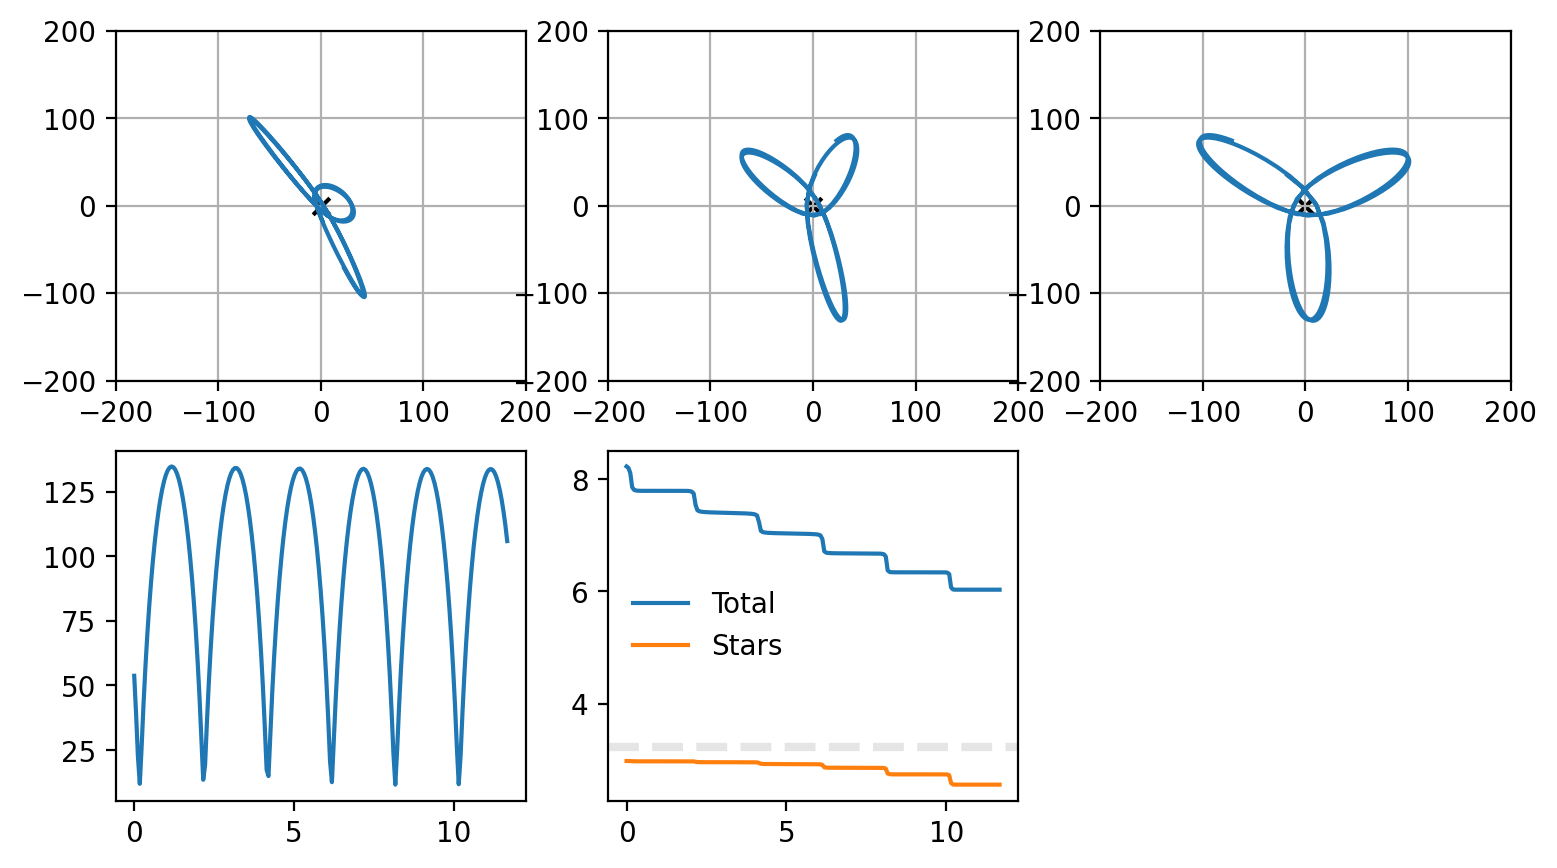

In [438]:
# Look a the results

R = solution['orbit'].xvArray[:,0]
P = solution['orbit'].xvArray[:,1]
Z = solution['orbit'].xvArray[:,2]

X = R*np.cos(P)
Y = R*np.sin(P)

pl.figure(figsize=(9,5))
ax1 = pl.subplot(2,3,1)
pl.plot(X,Y)

ax2 = pl.subplot(2,3,2)
pl.plot(X,Z)

ax3 = pl.subplot(2,3,3)
pl.plot(Y,Z)

ax4 = pl.subplot(2,3,4)
pl.plot(solution['tsteps'],solution['radii'])

ax5 = pl.subplot(2,3,5)
pl.plot(solution['tsteps'],np.log10(solution['prog_masses']),label='Total')
pl.plot(solution['tsteps'],np.log10(solution['prog_mstars']),label='Stars')

# This "resolution limit" phi_res is built in to the satgen orbit integrator;
# It can be adjusted by setting cfg.phi_res before the evolution calculation.
# The orbit is not updated after the total mass reaches this limit.
halo_mass_resolution_limit_rel = cfg.phi_res*prog.dens_profile.Mh
pl.axhline(np.log10(halo_mass_resolution_limit_rel),c='k',alpha=0.1,lw=3,ls='--')

# There is another "resolution limit"  built in to the satgen orbit integrator,
# cfg.Mres. In this case the limit is in absolute rather than relative mass.
# Again, the orbit is not updated after the total mass reaches this limit. 
# By default, cfg.Mres is None.
if cfg.Mres is not None:
    halo_mass_resolution_limit_abs = cfg.Mres
    pl.axhline(np.log10(halo_mass_resolution_limit_abs),c='g',alpha=0.1,lw=3,ls='--')

# Note that strange things happen if both limits are set and 
# cfg.Mres < cfg.phi_res * (initial halo mass)
    
pl.legend(frameon=False)

for ax in [ax1,ax2,ax3]:
    pl.sca(ax)
    pl.scatter([0],[0],c='k',marker='x')
    pl.grid()
    pl.xlim(-200,200)
    pl.ylim(-200,200)
    


In [439]:
# An example progenitor chosen from the list above

itree = 0
iprog = 426

prog_this_tree = np.flatnonzero(progenitors['TreeID'] == itree)

prog_zred = progenitors['ProgenitorZred'][prog_this_tree]
prog_ilev = progenitors['ProgenitorIlev'][prog_this_tree] 
prog_mass = progenitors['ProgenitorMass'][prog_this_tree]

host_mass = tree_main_branch_masses[itree,:]

np.random.seed(2026)
host_ref = Host(host_mass, tree_redshifts, cosmology)
prog_ref = Progenitor(prog_mass[iprog], host_ref, level=prog_ilev[iprog])

NameError: name 'Host' is not defined

In [440]:
# A: 1000 timesteps 

# The total time from infall to z=0
total_time_gyr = prog.infall_t_lbk
nsteps_a = 1000

# tsteps grid and output array sizes will be nsteps+1,
# because the initial conditions are included at index zero (t=0)
tsteps_a = np.linspace(0, total_time_gyr, nsteps_a+1)
dtstep_a = total_time_gyr/nsteps_a

In [441]:
# B: 300 timesteps

# The total time from infall to z=0
total_time_gyr = prog.infall_t_lbk
nsteps_b = 300

# tsteps grid and output array sizes will be nsteps+1,
# because the initial conditions are included at index zero (t=0)
tsteps_b = np.linspace(0, total_time_gyr, nsteps_b+1)
dtstep_b = total_time_gyr/nsteps_b

In [881]:
solution_a = evolve_orbit(host_ref, prog_ref, tsteps_a, evolve_prog_mass=True)
solution_b = evolve_orbit(host_ref, prog_ref, tsteps_b, evolve_prog_mass=True)

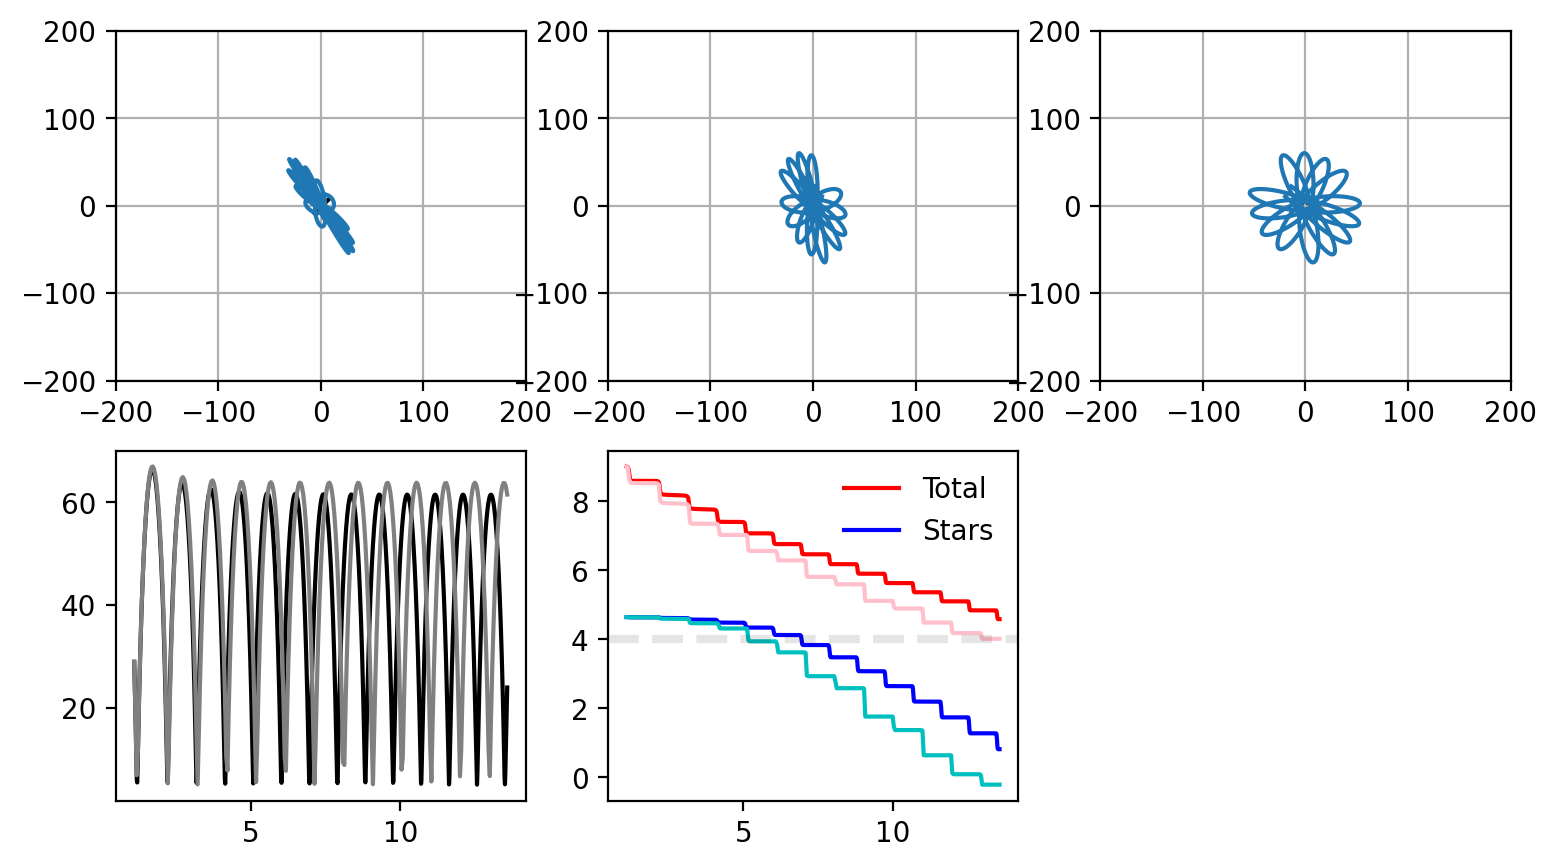

In [882]:
# Look a the results

Ra = solution_a['orbit'].xvArray[:,0]
Pa = solution_a['orbit'].xvArray[:,1]
Za = solution_a['orbit'].xvArray[:,2]

Rb = solution_b['orbit'].xvArray[:,0]
Pb = solution_b['orbit'].xvArray[:,1]
Zb = solution_b['orbit'].xvArray[:,2]

Xa = Ra*np.cos(Pa)
Ya = Ra*np.sin(Pa)

Xb = Rb*np.cos(Pb)
Yb = Rb*np.sin(Pb)

pl.figure(figsize=(9,5))
ax1 = pl.subplot(2,3,1)
pl.plot(Xa,Ya)

ax2 = pl.subplot(2,3,2)
pl.plot(Xa,Za)

ax3 = pl.subplot(2,3,3)
pl.plot(Ya,Za)

ax4 = pl.subplot(2,3,4)
pl.plot(solution_a['tage'],solution_a['radii'],c='k')
ax4 = pl.subplot(2,3,4)
pl.plot(solution_b['tage'],solution_b['radii'],c='grey')

ax5 = pl.subplot(2,3,5)
pl.plot(solution_a['tage'],np.log10(solution_a['prog_masses']),label='Total',c='r')
pl.plot(solution_a['tage'],np.log10(solution_a['prog_mstars']),label='Stars',c='b')

pl.plot(solution_b['tage'],np.log10(solution_b['prog_masses']),c='pink')
pl.plot(solution_b['tage'],np.log10(solution_b['prog_mstars']),c='c')

# This "resolution limit" phi_res is built in to the satgen orbit integrator;
# It can be adjusted by setting cfg.phi_res before the evolution calculation.
# The orbit is not updated after the total mass reaches this limit.
halo_mass_resolution_limit_rel = cfg.phi_res*prog_ref.dens_profile.Mh
pl.axhline(np.log10(halo_mass_resolution_limit_rel),c='k',alpha=0.1,lw=3,ls='--')

# There is another "resolution limit"  built in to the satgen orbit integrator,
# cfg.Mres. In this case the limit is in absolute rather than relative mass.
# Again, the orbit is not updated after the total mass reaches this limit. 
# By default, cfg.Mres is None.
if cfg.Mres is not None:
    halo_mass_resolution_limit_abs = cfg.Mres
    pl.axhline(np.log10(halo_mass_resolution_limit_abs),c='g',alpha=0.1,lw=3,ls='--')

# Note that strange things happen if both limits are set and 
# cfg.Mres < cfg.phi_res * (initial halo mass)
    
pl.legend(frameon=False)

for ax in [ax1,ax2,ax3]:
    pl.sca(ax)
    pl.scatter([0],[0],c='k',marker='x')
    pl.grid()
    pl.xlim(-200,200)
    pl.ylim(-200,200)
    


In [887]:
import numpy as np
from scipy.fft import rfft, rfftfreq

def estimate_period_fft(t, y):
    # Ensure t and y are numpy arrays
    t = np.asarray(t)
    y = np.asarray(y)

    # Calculate sampling interval and frequency
    dt = np.mean(np.diff(t))
    N  = len(y)

    # Compute FFT
    yf = np.abs(rfft(y - np.mean(y)))  # remove DC offset
    xf = rfftfreq(N, dt)

    # Ignore the zero frequency component
    yf[0] = 0

    # Find the peak frequency
    idx = np.argmax(yf)
    dominant_freq = xf[idx]

    # Compute period
    period = 1.0 / dominant_freq
    return period

In [891]:
estimate_period_fft(solution_a['tage'],solution_a['radii'])

0.961292028427124

Conclusion: in this example, for this tree time resolution, the orbit doesn't converge until n~1000 substeps. This corresponds to a timestep of 0.01 Gyr. The orbital period for this example is ~1 Gyr.

We can interpolate between levels in the tree.

Taking 10 timesteps between each level should be almost but not exactly equivalent to taking unit timesteps between 10 interpolated levels.

In [856]:
# An example progenitor chosen from the list above

itree = 0
iprog = 426

prog_this_tree = np.flatnonzero(progenitors['TreeID'] == itree)

prog_zred = progenitors['ProgenitorZred'][prog_this_tree]
prog_ilev = progenitors['ProgenitorIlev'][prog_this_tree] 
prog_mass = progenitors['ProgenitorMass'][prog_this_tree]

host_mass = tree_main_branch_masses[itree,:]

In [870]:
# A: Tree grid, subdivided into 10 substeps per step
np.random.seed(2026)
host_a = Host(host_mass, tree_redshifts, cosmology)
prog_a = Progenitor(prog_mass[iprog], host_a, level=prog_ilev[iprog])

# The total time from infall to z=0
total_time_gyr = prog_a.infall_t_lbk
nsubsteps_a = 10

# tsteps grid and output array sizes will be (nsteps*nsubsteps)+1,
# because the initial conditions are included at index zero (t=0)
tsteps_a = list()
for ilev in range(0,prog_a.level):
    t_i = host_a.t_lbk[ilev]
    t_f = host_a.t_lbk[ilev+1]
    # The last step is counted in the next level
    tsubsteps = np.linspace(t_i, t_f, nsubsteps_a+1)[:-1]
    tsteps_a.append(tsubsteps)

tsteps_a.append(np.atleast_1d(prog_a.infall_t_lbk))
tsteps_a = np.concatenate(tsteps_a)

In [871]:
%time solution_a = evolve_orbit(host_a, prog_a, tsteps_a, evolve_prog_mass=True)

CPU times: user 1.16 s, sys: 1.82 ms, total: 1.16 s
Wall time: 1.16 s


In [872]:
# B: Tree grid, interpolated at 10 intervals per step

nsubsteps_b = 10

# zred grid and output array sizes will be (nsteps*nsubsteps)+1,
# because the initial conditions are included at index zero (t=0)
zred_interpolate = list()
for ilev in range(0,prog_ilev[iprog]):
    # Note we used host_a
    z_i = tree_redshifts[ilev]
    z_f =tree_redshifts[ilev+1]
    # The last step is counted in the next level
    zsubsteps = np.linspace(z_i, z_f, nsubsteps_b+1)[:-1]
    zred_interpolate.append(zsubsteps)

zred_interpolate.append(np.atleast_1d(tree_redshifts[prog_ilev[iprog]]))
zred_interpolate = np.concatenate(zred_interpolate)

np.random.seed(2026)
host_b = Host(host_mass, tree_redshifts, cosmology, output_zred=zred_interpolate)
prog_b = Progenitor(prog_mass[iprog], host_b, level=prog_ilev[iprog])

tsteps_b = host_b.t_lbk

In [873]:
%time solution_b = evolve_orbit(host_b, prog_b, tsteps_b, evolve_prog_mass=True)

CPU times: user 1.17 s, sys: 917 μs, total: 1.17 s
Wall time: 1.17 s


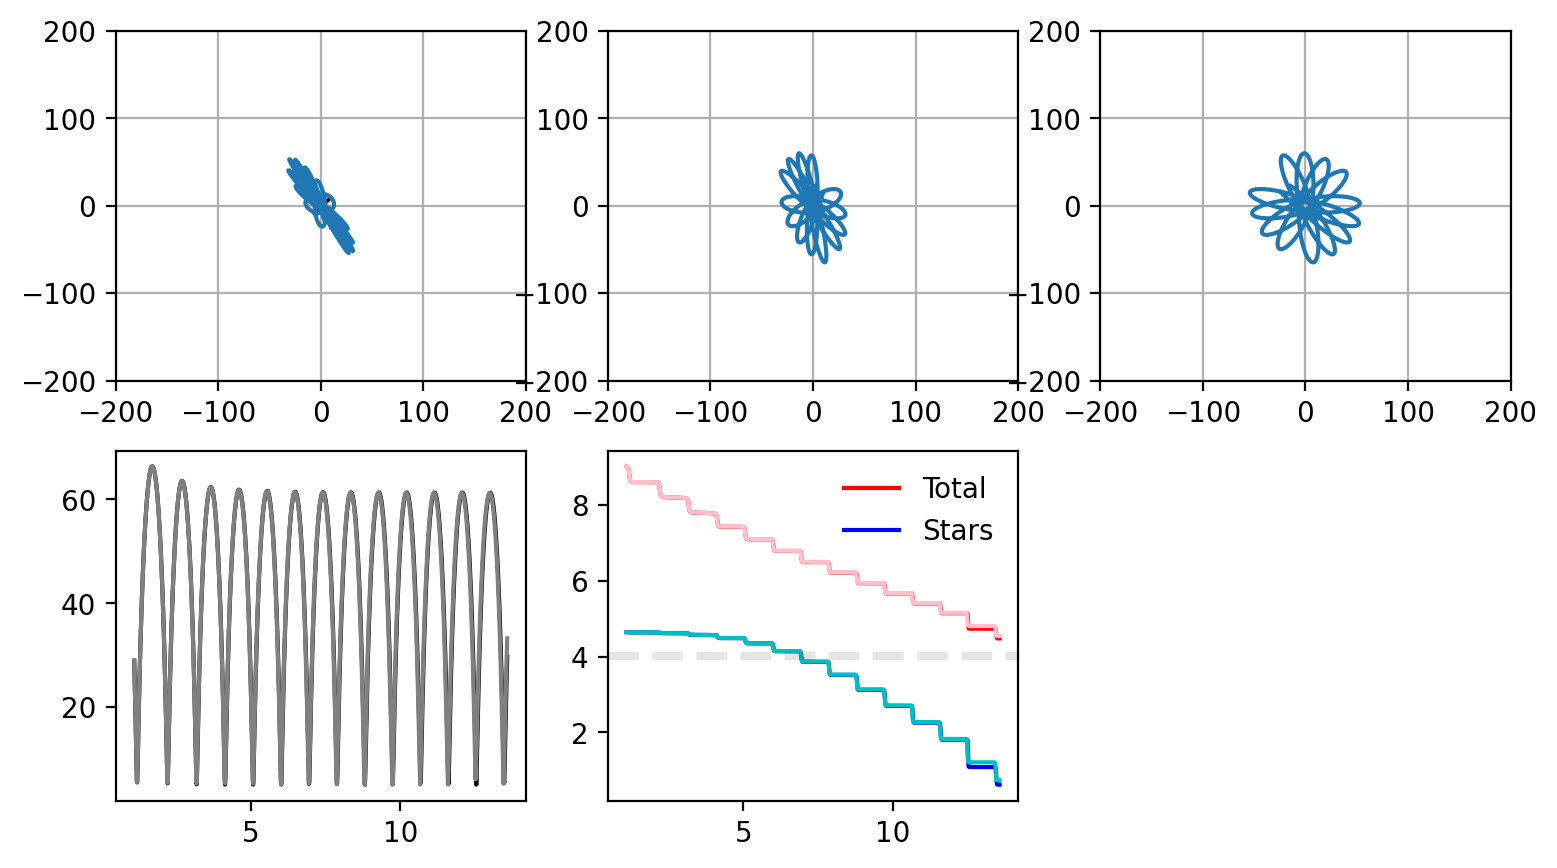

In [874]:
# Look a the results

Ra = solution_a['orbit'].xvArray[:,0]
Pa = solution_a['orbit'].xvArray[:,1]
Za = solution_a['orbit'].xvArray[:,2]

Rb = solution_b['orbit'].xvArray[:,0]
Pb = solution_b['orbit'].xvArray[:,1]
Zb = solution_b['orbit'].xvArray[:,2]

Xa = Ra*np.cos(Pa)
Ya = Ra*np.sin(Pa)

Xb = Rb*np.cos(Pb)
Yb = Rb*np.sin(Pb)

pl.figure(figsize=(9,5))
ax1 = pl.subplot(2,3,1)
pl.plot(Xa,Ya)

ax2 = pl.subplot(2,3,2)
pl.plot(Xa,Za)

ax3 = pl.subplot(2,3,3)
pl.plot(Ya,Za)

ax4 = pl.subplot(2,3,4)
pl.plot(solution_a['tage'],solution_a['radii'],c='k')
ax4 = pl.subplot(2,3,4)
pl.plot(solution_b['tage'],solution_b['radii'],c='grey')

ax5 = pl.subplot(2,3,5)
pl.plot(solution_a['tage'],np.log10(solution_a['prog_masses']),label='Total',c='r')
pl.plot(solution_a['tage'],np.log10(solution_a['prog_mstars']),label='Stars',c='b')

pl.plot(solution_b['tage'],np.log10(solution_b['prog_masses']),c='pink')
pl.plot(solution_b['tage'],np.log10(solution_b['prog_mstars']),c='c')

# This "resolution limit" phi_res is built in to the satgen orbit integrator;
# It can be adjusted by setting cfg.phi_res before the evolution calculation.
# The orbit is not updated after the total mass reaches this limit.
halo_mass_resolution_limit_rel = cfg.phi_res*prog_ref.dens_profile.Mh
pl.axhline(np.log10(halo_mass_resolution_limit_rel),c='k',alpha=0.1,lw=3,ls='--')

# There is another "resolution limit"  built in to the satgen orbit integrator,
# cfg.Mres. In this case the limit is in absolute rather than relative mass.
# Again, the orbit is not updated after the total mass reaches this limit. 
# By default, cfg.Mres is None.
if cfg.Mres is not None:
    halo_mass_resolution_limit_abs = cfg.Mres
    pl.axhline(np.log10(halo_mass_resolution_limit_abs),c='g',alpha=0.1,lw=3,ls='--')

# Note that strange things happen if both limits are set and 
# cfg.Mres < cfg.phi_res * (initial halo mass)
    
pl.legend(frameon=False)

for ax in [ax1,ax2,ax3]:
    pl.sca(ax)
    pl.scatter([0],[0],c='k',marker='x')
    pl.grid()
    pl.xlim(-200,200)
    pl.ylim(-200,200)

There is no significant difference in the time taken (since the number of timesteps is the same in each case).

For more than 5 substeps, the difference in the results is small. 

Conclusion: for this example, at this tree time resolution, interpolating the halo properties does not make much difference.

# TODO

### Disk parameters / evolution

* How to choose f_d and flattening?
* Should we consider disk collapse and regrowth?
* How is the disk size set?

Green et al. find that the flattening doesn't make much difference, so below the knee, it doesn't matter if the "disk" is sometimes an "elliptical" (especially because we'll remove the most obvious "elliptical" cases (late major mergers) from the sample at the end anyway.

The disk fraction is set from the SMHM relation, which we assume is dominated by in situ mstar.

The size needs to be consistent with the halo concentration. Can we use MMW?

### Growth in Mstar

In principle we want the stellar mass at z=0 to correlate with the growth history, e.g. galaxies that are above Mstar-Mhalo at z=0 grew faster in the past. This is hard to do without physics!

In [452]:
# An example tree
itree = 20
itree = 25

prog_this_tree = np.flatnonzero(progenitors['TreeID'] == itree)

In [453]:
# The main branch masses are in descending order; level 0 is the root of the tree.

# This is the total mass at a given level that will merge into the MB by the NEXT level
# The extra entry is for book-keeping later
prog_total_mass_per_level = np.zeros(nlev+1)
prog_mass_this_tree       = progenitors['ProgenitorMass'][prog_this_tree]
prog_ilev_this_tree       = progenitors['ProgenitorIlev'][prog_this_tree]

for ilev in range(0,nlev):
    prog_total_mass_per_level[ilev] = np.sum(prog_mass_this_tree[prog_ilev_this_tree == ilev])

prog_total_mass_per_level_cumul = np.cumsum(prog_total_mass_per_level[::-1])[::-1]

tree_main_branch_smooth_masses = tree_main_branch_masses[itree,:] - prog_total_mass_per_level_cumul[1:]

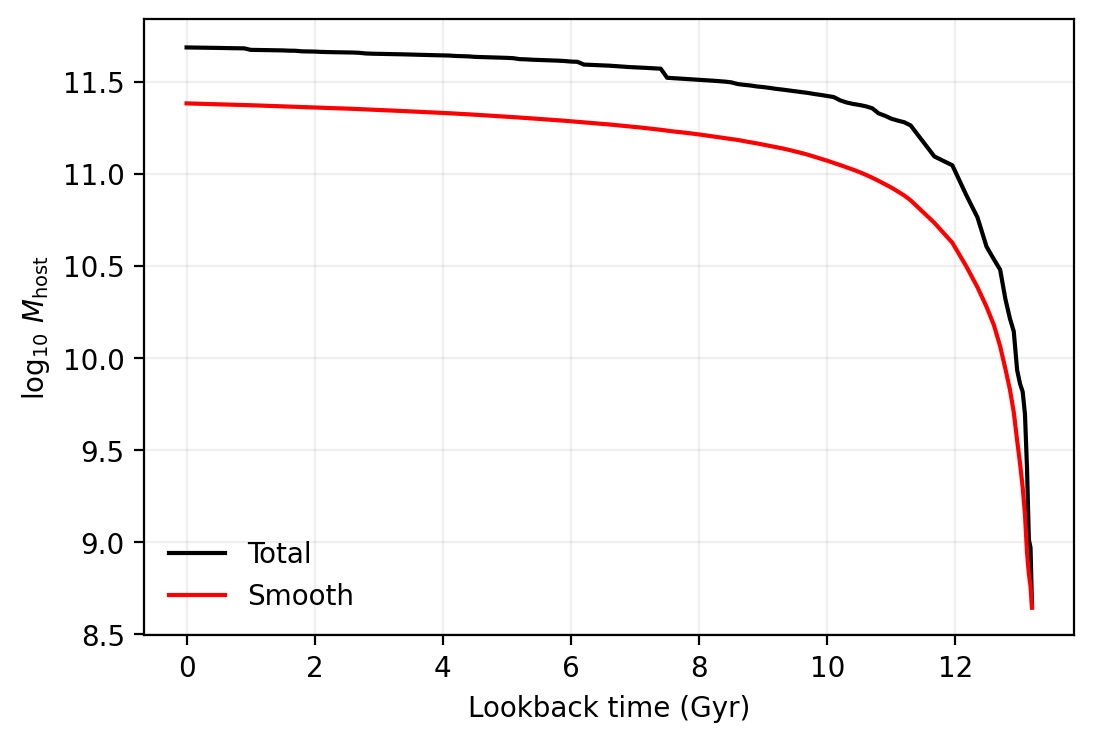

In [454]:
# Plot the mass growth history
pl.figure(figsize=(6,4))
pl.plot(tree_t_lbk_gyr, np.log10(tree_main_branch_masses[itree,:]),c='k', label='Total')
pl.plot(tree_t_lbk_gyr, np.log10(tree_main_branch_smooth_masses),c='r', label='Smooth')

pl.grid(alpha=0.2)
pl.xlabel('Lookback time (Gyr)')
pl.ylabel('$\log_{10}\,M_\mathrm{host}$');
pl.legend(frameon=False);

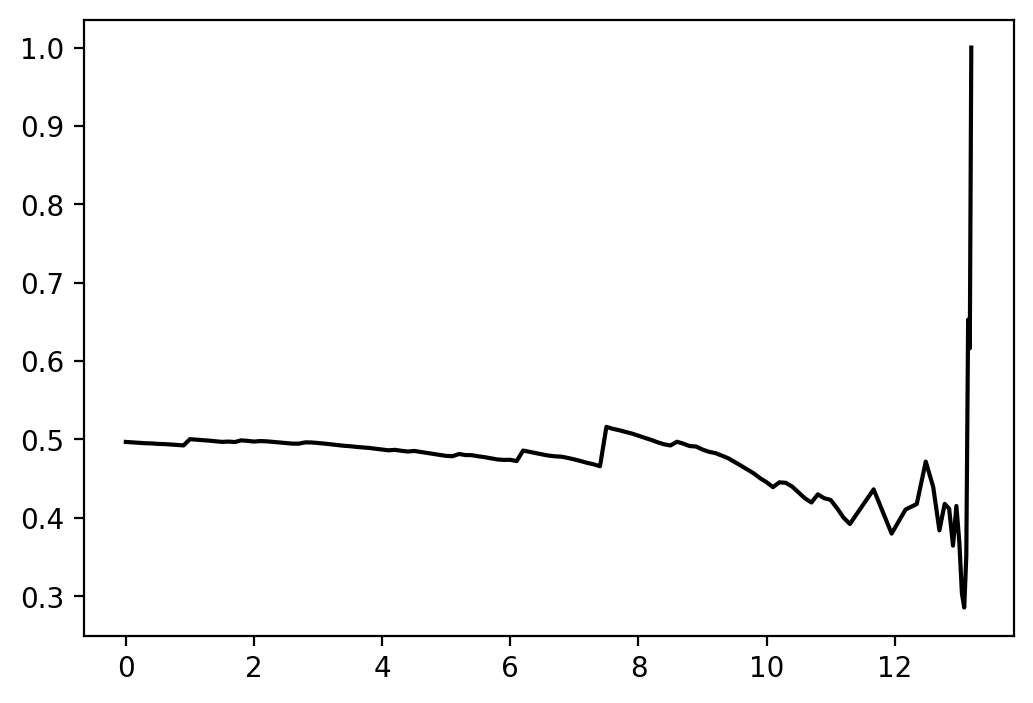

In [456]:
pl.figure(figsize=(6,4))
pl.plot(tree_t_lbk_gyr, (tree_main_branch_smooth_masses/tree_main_branch_masses[itree,:]),c='k')


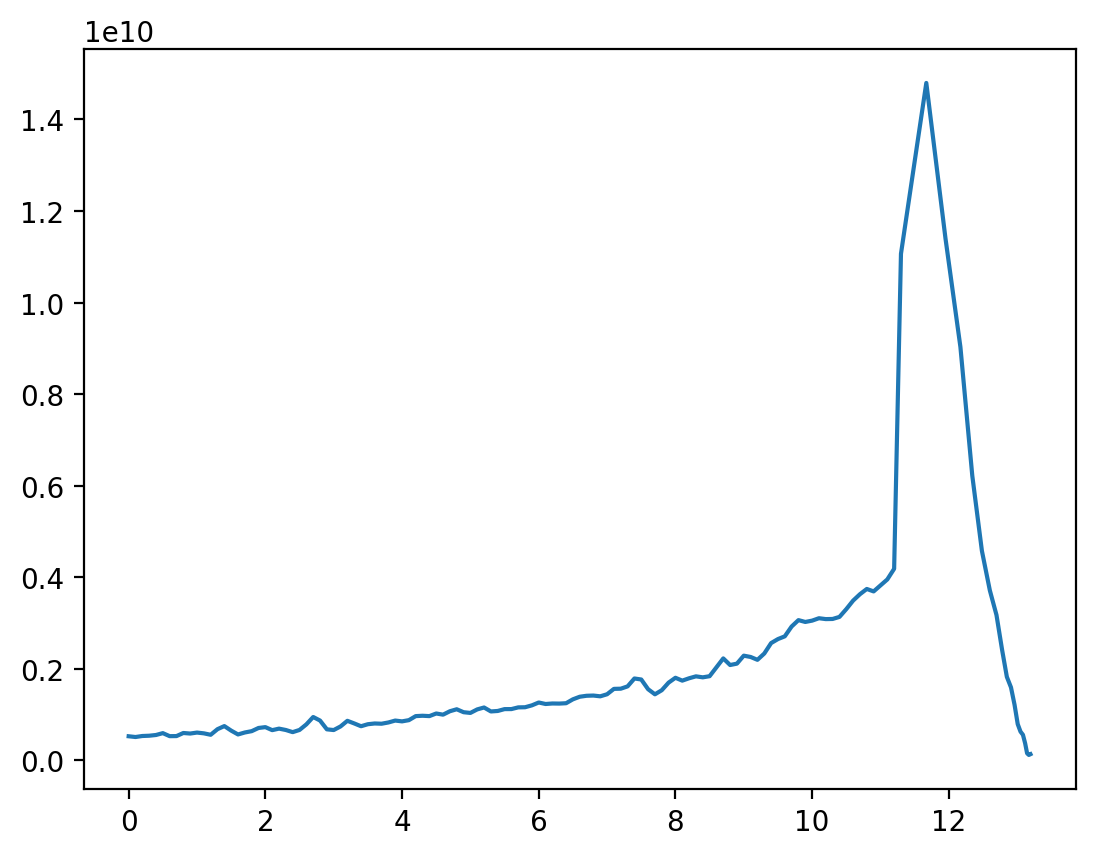

In [265]:
pl.plot(tree_t_lbk_gyr,np.gradient(tree_main_branch_smooth_masses[::-1])[::-1])

In [268]:
if hasattr(host,"disk_dens_profile")

True